In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi


Tue Jul 29 11:35:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [4]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [5]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [6]:
import torch
print("✅ PyTorch version:", torch.__version__)


✅ PyTorch version: 2.6.0+cu124


In [7]:
print("✅ CUDA Available:", torch.cuda.is_available())
print("🖥️  GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


✅ CUDA Available: True
🖥️  GPU Name: Tesla T4


In [8]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x * 2
z = y.sum()
z.backward()

print("🎯 x:", x)
print("🎯 Gradient of x:", x.grad)


🎯 x: tensor([1., 2., 3.], requires_grad=True)
🎯 Gradient of x: tensor([2., 2., 2.])


In [ ]:
!pip install numpy --upgrade --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
raft-dask-cu12 25.6.0 requires nvidia-nccl-cu12>=2.19, but you have nvidia-nccl-cu12 2.18.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.


In [55]:
!pip uninstall -y numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [57]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
raft-dask-cu12 25.6.0 requires nvidia-nccl-cu12>=2.19, but you have nvidia-nccl-cu12 2.18.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [12]:
import numpy as np
print("✅ NumPy version:", np.__version__)


✅ NumPy version: 2.0.2


In [ ]:
from tqdm import tqdm


In [13]:
# ✅ MobileViTv3-Small Training with Fixed Fusion, Resume, Cosine LR, Accuracy Logging
import os, json, torch
import numpy as np
from tqdm import tqdm
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F

# ---------------- MobileViTv3-Small Model ---------------- #
class ConvNormAct(nn.Sequential):
    def __init__(self, in_chs, out_chs, kernel_size, stride=1, groups=1, act_layer=nn.SiLU):
        padding = kernel_size // 2
        super().__init__(
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_chs),
            act_layer()
        )

class InvertedResidual(nn.Module):
    def __init__(self, in_chs, out_chs, stride, expand_ratio):
        super().__init__()
        hidden_dim = int(round(in_chs * expand_ratio))
        self.use_res_connect = stride == 1 and in_chs == out_chs
        self.conv = nn.Sequential(
            ConvNormAct(in_chs, hidden_dim, kernel_size=1),
            ConvNormAct(hidden_dim, hidden_dim, kernel_size=3, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, out_chs, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_chs),
        )

    def forward(self, x):
        return x + self.conv(x) if self.use_res_connect else self.conv(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=4, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim), nn.Dropout(dropout)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x.reshape(B, H, W, C).permute(0, 3, 1, 2)

class MobileViTBlock(nn.Module):
    def __init__(self, in_chs, transformer_dim, depth, patch_size=2):
        super().__init__()
        self.patch_size = patch_size
        self.local_rep = nn.Sequential(
            ConvNormAct(in_chs, in_chs, 3),
            nn.Conv2d(in_chs, transformer_dim, kernel_size=1)
        )
        self.transformer = nn.Sequential(
            *[TransformerBlock(transformer_dim) for _ in range(depth)]
        )
        # ✅ Corrected: input is in_chs + transformer_dim after concatenation
        self.fusion = ConvNormAct(in_chs + transformer_dim, in_chs, 3)

    def forward(self, x):
        res = x
        x = self.local_rep(x)
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size
        x = F.unfold(x, kernel_size=(ph, pw), stride=(ph, pw)).transpose(1, 2)
        N = x.size(1)
        x = x.view(B, N, C, ph, pw).mean(dim=[3,4])
        x = x.view(B, int(H/ph), int(W/pw), C).permute(0, 3, 1, 2)
        x = self.transformer(x)
        x = F.interpolate(x, size=res.shape[2:], mode='bilinear', align_corners=False)
        x = self.fusion(torch.cat((res, x), dim=1))
        return x


class MobileViTv3Small(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = ConvNormAct(3, 16, 3, stride=2)
        self.stage1 = InvertedResidual(16, 32, stride=1, expand_ratio=2)
        self.stage2 = InvertedResidual(32, 48, stride=2, expand_ratio=2)
        self.stage3 = InvertedResidual(48, 64, stride=2, expand_ratio=2)
        self.mv2_block1 = MobileViTBlock(64, transformer_dim=96, depth=2)
        self.mv2_block2 = MobileViTBlock(64, transformer_dim=128, depth=2)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.mv2_block1(x)
        x = self.mv2_block2(x)
        return self.head(x)

# ---------------- Step 1: Config ---------------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
history_path = '/content/drive/MyDrive/MobileViT_v3_history.json'
model_path = '/content/drive/MyDrive/MobileViT_v3_final.pth'

image_size = 256
batch_size = 16
total_epochs = 15
lr = 1e-3
weight_decay = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ---------------- Step 2: Transforms & Dataset ---------------- #
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=val_transform)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names   = train_dataset.classes
num_classes   = len(class_names)
print("🧾 Classes:", class_names)

# ---------------- Step 3: Model, Optimizer, Scheduler ---------------- #
model = MobileViTv3Small(num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs)
loss_fn = nn.CrossEntropyLoss()

# ---------------- Step 4: Resume Support ---------------- #
start_epoch = 0
history = {
    "train_loss": [], "train_accuracy": [], "val_accuracy": [],
    "val_precision": [], "val_recall": [], "val_f1": []
}
if os.path.exists(model_path):
    print("🔁 Resuming from checkpoint...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
            start_epoch = len(history["train_loss"])
    print(f"🔁 Resumed from epoch {start_epoch}/{total_epochs}")

# ---------------- Step 5: Evaluation Function ---------------- #
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)
    return acc, prec, rec, f1

# ---------------- Step 6: Training Loop ---------------- #
for epoch in range(start_epoch, total_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)

    # Eval
    train_acc = evaluate(model, train_loader)[0]
    val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)

    # History
    history["train_loss"].append(avg_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(val_acc)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)

    with open(history_path, 'w') as f:
        json.dump(history, f)
    torch.save(model.state_dict(), model_path)

    print(f"\n✅ Epoch {epoch+1} Complete:")
    print(f"   🔻 Loss         : {avg_loss:.4f}")
    print(f"   🎯 Train Acc    : {train_acc:.4f}")
    print(f"   🎯 Val Accuracy : {val_acc:.4f}")
    print(f"   🎯 Val Precision: {val_prec:.4f}")
    print(f"   🔁 Val Recall   : {val_rec:.4f}")
    print(f"   📈 Val F1 Score : {val_f1:.4f}")

# ---------------- Step 7: Done ---------------- #
print("✅ Training complete. Model + history saved to Drive.")


✅ Using device: cuda
🧾 Classes: ['NORMAL', 'PNEUMONIA']


Epoch 1/15: 100%|██████████| 327/327 [48:00<00:00,  8.81s/it]



✅ Epoch 1 Complete:
   🔻 Loss         : 0.3261
   🎯 Train Acc    : 0.9071
   🎯 Val Accuracy : 0.9118
   🎯 Val Precision: 0.9317
   🔁 Val Recall   : 0.9489
   📈 Val F1 Score : 0.9402


Epoch 2/15: 100%|██████████| 327/327 [00:49<00:00,  6.59it/s]



✅ Epoch 2 Complete:
   🔻 Loss         : 0.2481
   🎯 Train Acc    : 0.8246
   🎯 Val Accuracy : 0.9015
   🎯 Val Precision: 0.9795
   🔁 Val Recall   : 0.8837
   📈 Val F1 Score : 0.9291


Epoch 3/15: 100%|██████████| 327/327 [00:50<00:00,  6.48it/s]



✅ Epoch 3 Complete:
   🔻 Loss         : 0.2225
   🎯 Train Acc    : 0.8809
   🎯 Val Accuracy : 0.9041
   🎯 Val Precision: 0.9704
   🔁 Val Recall   : 0.8960
   📈 Val F1 Score : 0.9317


Epoch 4/15: 100%|██████████| 327/327 [00:50<00:00,  6.49it/s]



✅ Epoch 4 Complete:
   🔻 Loss         : 0.3892
   🎯 Train Acc    : 0.5078
   🎯 Val Accuracy : 0.5222
   🎯 Val Precision: 0.9226
   🔁 Val Recall   : 0.3780
   📈 Val F1 Score : 0.5363


Epoch 5/15: 100%|██████████| 327/327 [00:49<00:00,  6.62it/s]



✅ Epoch 5 Complete:
   🔻 Loss         : 0.3919
   🎯 Train Acc    : 0.8516
   🎯 Val Accuracy : 0.8667
   🎯 Val Precision: 0.8899
   🔁 Val Recall   : 0.9330
   📈 Val F1 Score : 0.9110


Epoch 6/15: 100%|██████████| 327/327 [00:48<00:00,  6.68it/s]



✅ Epoch 6 Complete:
   🔻 Loss         : 0.3306
   🎯 Train Acc    : 0.8860
   🎯 Val Accuracy : 0.8867
   🎯 Val Precision: 0.9502
   🔁 Val Recall   : 0.8916
   📈 Val F1 Score : 0.9200


Epoch 7/15: 100%|██████████| 327/327 [00:49<00:00,  6.62it/s]



✅ Epoch 7 Complete:
   🔻 Loss         : 0.2938
   🎯 Train Acc    : 0.8699
   🎯 Val Accuracy : 0.8667
   🎯 Val Precision: 0.9706
   🔁 Val Recall   : 0.8432
   📈 Val F1 Score : 0.9024


Epoch 8/15: 100%|██████████| 327/327 [00:48<00:00,  6.71it/s]



✅ Epoch 8 Complete:
   🔻 Loss         : 0.2757
   🎯 Train Acc    : 0.9232
   🎯 Val Accuracy : 0.9292
   🎯 Val Precision: 0.9392
   🔁 Val Recall   : 0.9656
   📈 Val F1 Score : 0.9522


Epoch 9/15: 100%|██████████| 327/327 [00:49<00:00,  6.64it/s]



✅ Epoch 9 Complete:
   🔻 Loss         : 0.2246
   🎯 Train Acc    : 0.8929
   🎯 Val Accuracy : 0.9008
   🎯 Val Precision: 0.8908
   🔁 Val Recall   : 0.9850
   📈 Val F1 Score : 0.9356


Epoch 10/15: 100%|██████████| 327/327 [00:50<00:00,  6.50it/s]



✅ Epoch 10 Complete:
   🔻 Loss         : 0.2253
   🎯 Train Acc    : 0.9194
   🎯 Val Accuracy : 0.9214
   🎯 Val Precision: 0.9720
   🔁 Val Recall   : 0.9189
   📈 Val F1 Score : 0.9447


Epoch 11/15: 100%|██████████| 327/327 [00:49<00:00,  6.56it/s]



✅ Epoch 11 Complete:
   🔻 Loss         : 0.2055
   🎯 Train Acc    : 0.9353
   🎯 Val Accuracy : 0.9266
   🎯 Val Precision: 0.9645
   🔁 Val Recall   : 0.9339
   📈 Val F1 Score : 0.9490


Epoch 12/15: 100%|██████████| 327/327 [00:49<00:00,  6.60it/s]



✅ Epoch 12 Complete:
   🔻 Loss         : 0.1967
   🎯 Train Acc    : 0.9343
   🎯 Val Accuracy : 0.9330
   🎯 Val Precision: 0.9734
   🔁 Val Recall   : 0.9339
   📈 Val F1 Score : 0.9532


Epoch 13/15: 100%|██████████| 327/327 [00:49<00:00,  6.59it/s]



✅ Epoch 13 Complete:
   🔻 Loss         : 0.1844
   🎯 Train Acc    : 0.9397
   🎯 Val Accuracy : 0.9330
   🎯 Val Precision: 0.9734
   🔁 Val Recall   : 0.9339
   📈 Val F1 Score : 0.9532


Epoch 14/15: 100%|██████████| 327/327 [00:50<00:00,  6.44it/s]



✅ Epoch 14 Complete:
   🔻 Loss         : 0.1841
   🎯 Train Acc    : 0.9452
   🎯 Val Accuracy : 0.9485
   🎯 Val Precision: 0.9575
   🔁 Val Recall   : 0.9727
   📈 Val F1 Score : 0.9650


Epoch 15/15: 100%|██████████| 327/327 [00:49<00:00,  6.54it/s]



✅ Epoch 15 Complete:
   🔻 Loss         : 0.1803
   🎯 Train Acc    : 0.9445
   🎯 Val Accuracy : 0.9472
   🎯 Val Precision: 0.9639
   🔁 Val Recall   : 0.9639
   📈 Val F1 Score : 0.9639
✅ Training complete. Model + history saved to Drive.


In [14]:
import json

# ✅ Load training history for MobileViT v3
with open('/content/drive/MyDrive/MobileViT_v3_history.json', 'r') as f:
    history = json.load(f)

# ✅ Extract final epoch's training and validation accuracy
final_train_acc = history['train_accuracy'][-1]
final_val_acc   = history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc * 100:.2f}%")


✅ Final Training Accuracy   : 94.45%
✅ Final Validation Accuracy : 94.72%


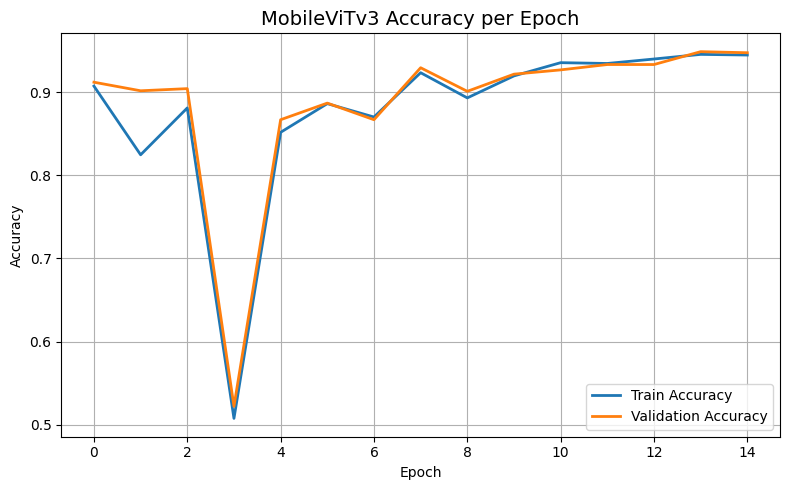

In [15]:
import matplotlib.pyplot as plt
import json

# ✅ Load training history for MobileViTv3
with open('/content/drive/MyDrive/MobileViT_v3_history.json', 'r') as f:
    history = json.load(f)

# ✅ Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['train_accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('MobileViTv3 Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


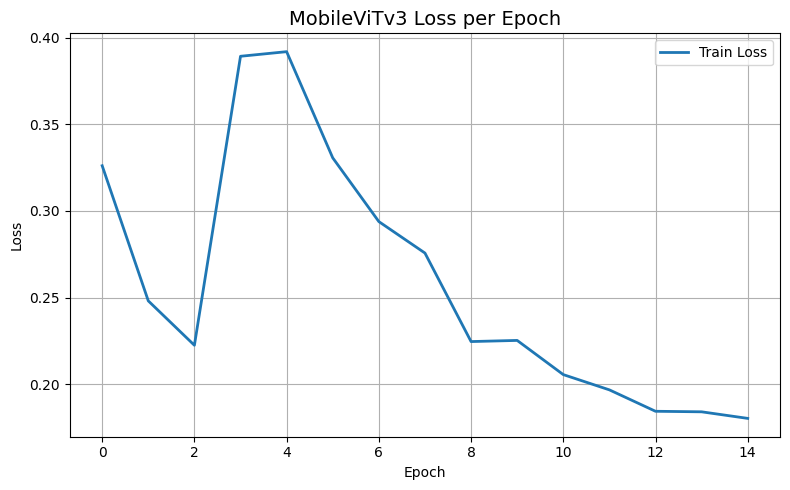

In [16]:
import matplotlib.pyplot as plt
import json

# ✅ Load training history for MobileViTv3
with open('/content/drive/MyDrive/MobileViT_v3_history.json', 'r') as f:
    history = json.load(f)

# ✅ Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.title('MobileViTv3 Loss per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
final_model_path = '/content/drive/MyDrive/MobileViT_v3_final.pth'
batch_size = 16
image_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# -------- TRANSFORM -------- #
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# -------- DATASET -------- #
test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes
print("🧾 Classes:", class_names)

# -------- MODEL DEF -------- #
# (Insert full MobileViTv3Small model definition here – same as in training script)

# -------- LOAD MODEL -------- #
model = MobileViTv3Small(num_classes=len(class_names))
model.load_state_dict(torch.load(final_model_path, map_location=device))
model.to(device)
model.eval()

# -------- EVALUATE -------- #
criterion = nn.CrossEntropyLoss()
total_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="🔍 Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = total_loss / total
test_accuracy = correct / total

print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {avg_test_loss:.4f}")


✅ Using device: cuda
🧾 Classes: ['NORMAL', 'PNEUMONIA']


🔍 Evaluating: 100%|██████████| 98/98 [14:52<00:00,  9.10s/it]

✅ Test Accuracy: 95.24%
📉 Test Loss: 0.1240


📊 Overall Model Performance (MobileViTv3-Small, Threshold = 0.50):

✅ Accuracy :  0.9524
🎯 Precision: 0.9717
🔁 Recall   : 0.9632
📈 F1 Score : 0.9674


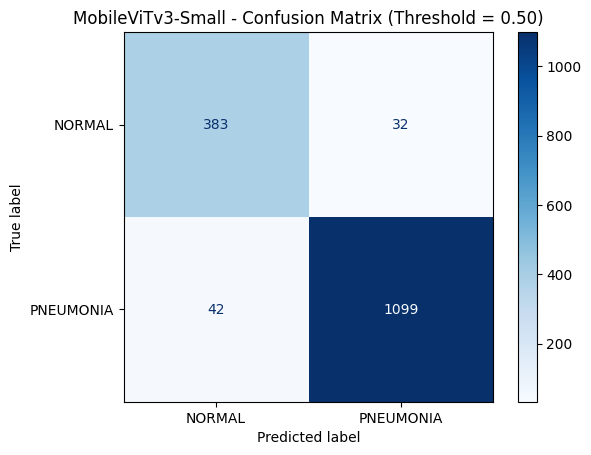


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1099
✅ True Negatives (TN): 383
❌ False Positives (FP): 32
❌ False Negatives (FN): 42


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
batch_size = 64
image_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Step 1: True labels from generator -------- #
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
y_true = np.array([label for _, label in test_dataset])

# -------- Step 2: Model predictions -------- #
model = MobileViTv3Small(num_classes=2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/MobileViT_v3_final.pth', map_location=device))
model.eval()

y_pred_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class "PNEUMONIA"
        y_pred_probs.extend(probs.cpu().numpy())
y_pred_probs = np.array(y_pred_probs)

# -------- Step 3: Apply threshold (e.g. 0.5) -------- #
threshold = 0.50
y_pred = (y_pred_probs > threshold).astype(int).reshape(-1)

# -------- Step 4: Metrics -------- #
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

# -------- Step 5: Print metrics -------- #
print("📊 Overall Model Performance (MobileViTv3-Small, Threshold = 0.50):\n")
print(f"✅ Accuracy :  {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# -------- Step 6: Confusion Matrix -------- #
cm = confusion_matrix(y_true, y_pred)
labels = test_dataset.classes  # e.g. ['NORMAL', 'PNEUMONIA']

# -------- Step 7: Plot Confusion Matrix -------- #
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("MobileViTv3-Small - Confusion Matrix (Threshold = 0.50)")
plt.grid(False)
plt.show()

# -------- Step 8: TP, TN, FP, FN Breakdown -------- #
tn, fp, fn, tp = cm.ravel()

print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
